# IMPORTS


In [1]:
# LIBRARIES


# interactive matplotlib plots
%matplotlib notebook
#%matplotlib inline

# imports
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib

import numpy as np

import math

import time
import datetime


# CLASSES

In [2]:
# CONVERTER CLASS
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int(round((x-self.xorigin)/self.pixsizex))
        newposy = int(round((y-self.yorigin)/self.pixsizey))
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int(round((i[0]-self.xorigin)/self.pixsizex))
            newposy = int(round((i[1]-self.yorigin)/self.pixsizey))
            newPointList.append((newposx, newposy))
        return newPointList


# FUNCTIONS 

In [3]:
# DISPLAYS THE NAMES OF THE ROIS IN THE STRUCTURE FILE
# @path: directory the file is
# @file: name of the structure file

def dispRoiNames(d):
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName, '(', 
              len(d.ROIContourSequence[i].ContourSequence), 'slices)')

In [4]:
# RETURNS A LIST OF POINTS CORRESPONDING TO THE STRUCTURE 
# @contourDataset: contour at the selected slice

def getPointList(contourDataset, dispNbPoints = False):
    c1 = contourDataset.ContourData
    nbpoints = int(contourDataset.NumberOfContourPoints) 
    if dispNbPoints: print("Nb of points in the structure on that slice:", nbpoints)

    pointList = []
    for i in range (0,nbpoints):
        x1 = c1[(i*3)]
        y1 = c1[(i*3)+1]
        pointList.append((x1, y1))

    return pointList

In [5]:
# RETURNS A DICTIONARY CONTAINING THE FILENAME CORRESPONDING TO EACH UI
# This method helps to get de filename of the CT slice corresponding to the 
# UI stored in the structure datafile
# @path: folder where all the CT slices are.

def getCTdictionary(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # gets the list of filenames:
    fpaths = [path + f for f in os.listdir(path) if ('.dcm' in f or '.DCM' in f)]
    
    # reads all files and creates dictionary
    n = 0
    CTdict = {}
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if ('Modality' in dir(f))and(f.Modality=='CT'):
            CTdict.update({f.SOPInstanceUID : fpath})
            n += 1
            
            
    if n==0: print('No CT file found in this directory.')
    
    return CTdict

In [6]:
# READS THE BINARY FILE OF AN IMAGE:

def readCastorInterfileAndImg(filename):

    # Reads interfile:
    dataoffset = 0
    nbofbytesperpix = 4
    sizex = 0
    sizey = 0
    sizez = 0
    pixsizex = 0
    pixsizey = 0
    pixsizez = 0
    offsetx = 0
    offsety = 0
    offsetz = 0
    rescaleoffset = 0
    rescaleslope = 1
    
    with open(filename) as f:
        for line in f:
            value = line.strip().split(' := ')
            if 'name of data file' in value[0]:
                imgfilename = value[1]
            elif 'data offset in bytes' in value[0]:
                dataoffset = value[1]
            elif 'number of bytes per pixel' in value[0]:
                nbofbytesperpix = value[1]
            elif 'matrix size [1]' in value[0]:
                sizex = int(value[1])
            elif 'matrix size [2]' in value[0]:
                sizey = int(value[1])
            elif 'matrix size [3]' in value[0]:
                sizez = int(value[1])
            elif 'data rescale offset' in value[0]:
                rescaleoffset = float(value[1])
            elif 'data rescale slope' in value[0]:
                rescaleslope = float(value[1])
            elif 'first pixel offset (mm) [1]' in value[0]:
                offsetx = float(value[1])
            elif 'first pixel offset (mm) [2]' in value[0]:
                offsety = float(value[1])
            elif 'first pixel offset (mm) [3]' in value[0]:
                offsetz = float(value[1])
            elif 'scaling factor (mm/pixel) [1]' in value[0]:
                pixsizex = float(value[1])
            elif 'scaling factor (mm/pixel) [2]' in value[0]:
                pixsizey = float(value[1])
            elif 'scaling factor (mm/pixel) [3]' in value[0]:
                pixsizez = float(value[1])
    
    imgtmp = np.fromfile(os.path.dirname(filename)+"/"+imgfilename, dtype=np.float32)
    
    img = np.zeros((sizez, sizey, sizex))
    for i in range(sizex):
        for j in range(sizey):
            for k in range(sizez):
                img[k, j, i] = imgtmp[k*sizex*sizey+j*sizex+i] * rescaleslope + rescaleoffset

    img = np.flip(img,1)
    
    return img, (sizez, sizey, sizex), (pixsizez, pixsizey, pixsizex), (offsetz, offsety, offsetx)

# MAIN

In [15]:
# Input parameters:

# DICOM Files (structures, SPECT & CT)
#m_structFile = 'imgs/homogene/CTstruct/RS1.2.752.243.1.1.20200619164054561.4000.34406.dcm'
#m_spectFile = 'imgs/homogene/20s/imgHomogene_scatterCorrSg_att_20s_it20.hdr'
#m_CTpath = 'imgs/homogene/CTstruct/'
m_structFile = 'imgs/test mimou/contours.dcm'
m_spectFile = 'imgs/test mimou/spect.DCM'
m_CTpath = 'imgs/test mimou/'

# ROI of interest
m_ROInb = 0

# Slice of interest for visualization purposes:
m_sliceNb = 50

# T1/2 isotope:
T1demi = 6.02*3600 # s

# SPECT Visualization window:
m_SPECTvmin = 0    # absolute value
m_SPECTvmax = 0.3  # *(max-min)+min

m_CTvmin = -100    # absolute value
m_CTvmax = 2000    # absolute value

In [16]:
# GETS THE IMPORTANT INFORMATION FROM THE FILES:

# reads the structure file and display ROI names:
m_struct = dicom.dcmread(m_structFile)
dispRoiNames(m_struct)


# Gets the dictionary UI:CTfilename
m_CTdict = getCTdictionary(m_CTpath)
print('\nDictionary containing UIDs and scan names created')


# Gets SPECT information:
# Reads the CT image corresponding to the slice of interest:
c_data = m_struct.ROIContourSequence[0].ContourSequence[0]
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])

m_CTxSpacing, m_CTySpacing = float(CTimg.PixelSpacing[0]), float(CTimg.PixelSpacing[1])
m_CTxOrigin, m_CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
m_CTsizeX, m_CTsizeY = CTimg.Rows, CTimg.Columns

print("\nCT Image information:")
print(" -> Image dimension in pixels: (", m_CTsizeX, "x", m_CTsizeY, ")")
print(" -> Pixel dimension in mm: (", m_CTxSpacing, "x", m_CTySpacing, ")")
print(" -> Image Origin in mm: (", m_CTxOrigin, "x", m_CTyOrigin, ",", CTzOrigin, ")\n")


# Reads the SPECT image corresponding to the slice of interest:
if (m_spectFile[-4:] == '.hdr') or (m_spectFile[-4:] == '.HDR') :
    m_SPECTarray, matrixsize, pixsize, origin = readCastorInterfileAndImg(m_spectFile)

    m_SPECTxSpacing, m_SPECTySpacing, m_SPECTzSpacing = float(pixsize[2]), float(pixsize[1]), float(pixsize[0])
    m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTzOrigin = origin[2], origin[1], origin[0]
    m_SPECTsizeX, m_SPECTsizeY = matrixsize[0], matrixsize[1]
    
    print("SPECT Image information:")
    print(" -> Format: Castor")
    print(" -> Image dimension in pixels: (", m_SPECTsizeX, "x", m_SPECTsizeY, ")")
    print(" -> Pixel dimension in mm: (", m_SPECTxSpacing, "x", m_SPECTySpacing, "x", m_SPECTzSpacing, ")")
    print(" -> Image Origin in mm: (", m_SPECTxOrigin, ",", m_SPECTyOrigin, ",", m_SPECTzOrigin, ")\n")

elif (m_spectFile[-4:] == '.dcm') or (m_spectFile[-4:] == '.DCM') :
    SPECTimg = dicom.read_file(m_spectFile)

    m_SPECTarray = SPECTimg.pixel_array
    m_SPECTxSpacing, m_SPECTySpacing = float(SPECTimg.PixelSpacing[0]), float(SPECTimg.PixelSpacing[1])
    m_SPECTzSpacing = SPECTimg[0x0018,0x0050].value
    [m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTzOrigin] = SPECTimg[0x0054,0x0022][0][0x0020,0X0032] 
    m_SPECTsizeX, m_SPECTsizeY = SPECTimg.Rows, SPECTimg.Columns
    
    print("SPECT Image information:")
    print(" -> Format: DICOM")
    print(" -> Image dimension in pixels: (", m_SPECTsizeX, "x", m_SPECTsizeY, ")")
    print(" -> Pixel dimension in mm: (", m_SPECTxSpacing, "x", m_SPECTySpacing, "x", m_SPECTzSpacing, ")")
    print(" -> Image Origin in mm: (", m_SPECTxOrigin, ",", m_SPECTyOrigin, ",", m_SPECTzOrigin, ")\n")

else:
    print("The SPECT image could not be read.")


The file contains 2 structures:
   0 : External ( 183 slices)
   1 : ext+1.6cm ( 208 slices)

Dictionary containing UIDs and scan names created

CT Image information:
 -> Image dimension in pixels: ( 512 x 512 )
 -> Pixel dimension in mm: ( 0.976562 x 0.976562 )
 -> Image Origin in mm: ( -250.000 x -250.000 , -98.750 )

SPECT Image information:
 -> Format: DICOM
 -> Image dimension in pixels: ( 128 x 128 )
 -> Pixel dimension in mm: ( 4.418156 x 4.418156 x 4.41816 )
 -> Image Origin in mm: ( -283.252906 , -277.852906 , 280.552906 )



Nb of points in the structure on that slice: 353


<IPython.core.display.Javascript object>


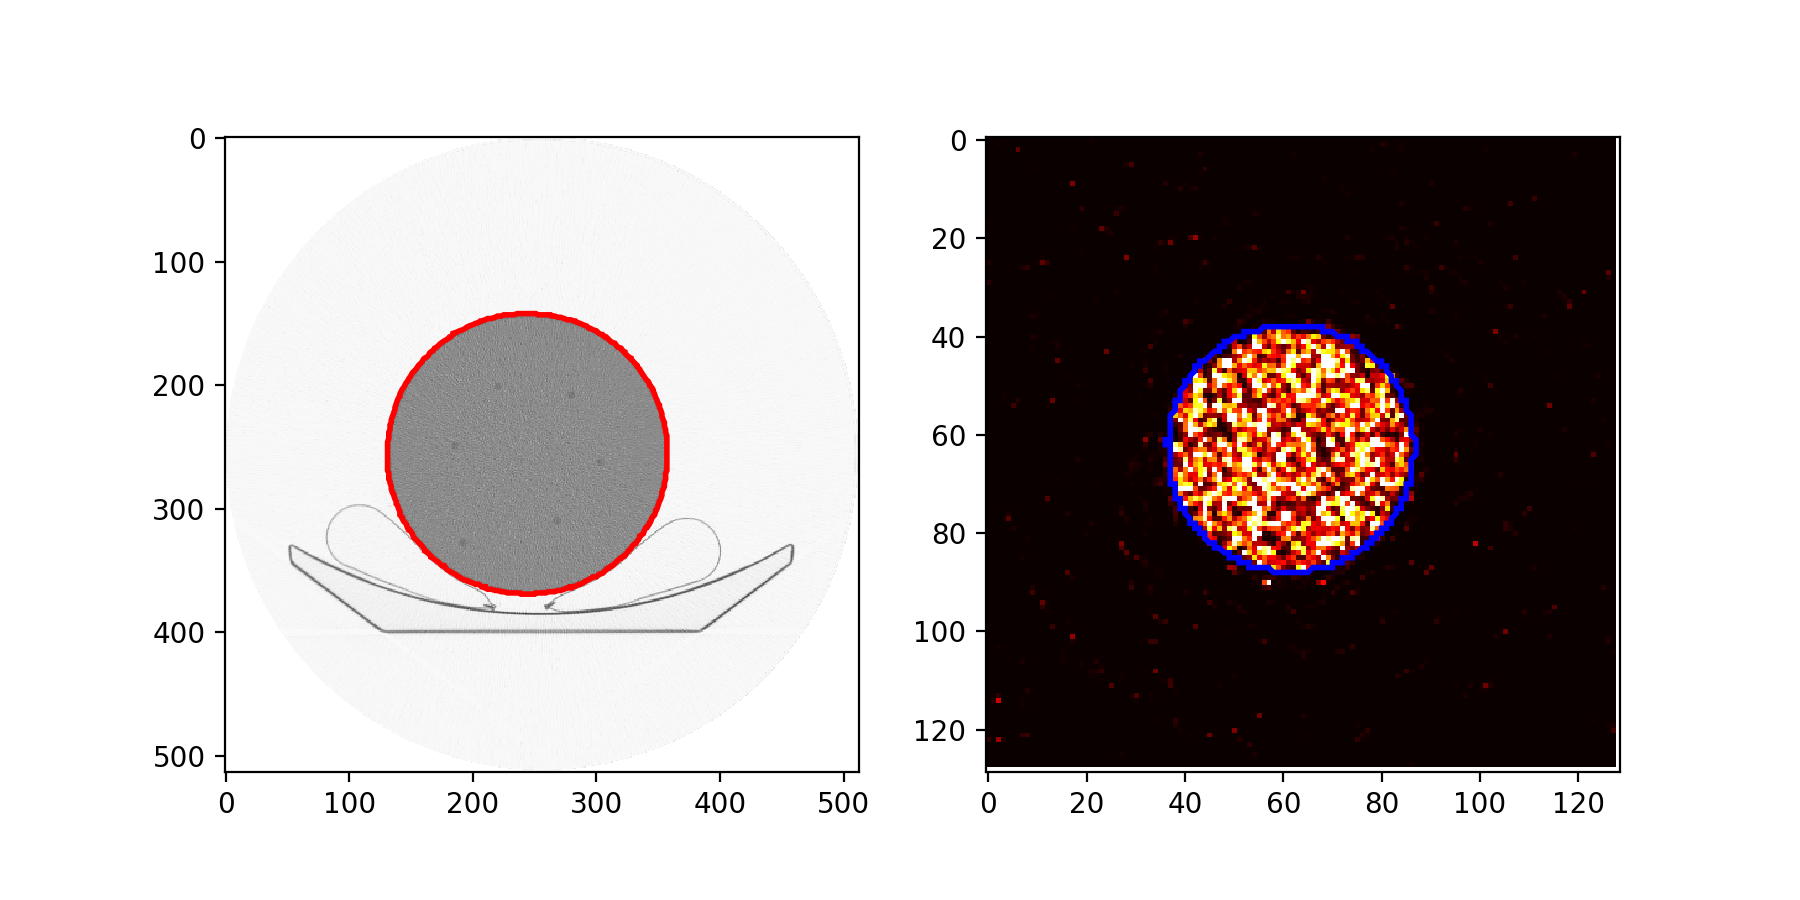

In [17]:
# DISPLAY STRUCTURE ON CT AND SPECT IMAGES TO VISUALLY CHECK
# THAT EVERYTHING'S ALL RIGHT (2D EVALUATION ONLY)

# get the list of points for the structure on the slice of interest:
c_data = m_struct.ROIContourSequence[m_ROInb].ContourSequence[m_sliceNb]

# Reads the list of points of the structure file on this slice of interest:
pointList = getPointList(c_data, dispNbPoints = True)


# Initialization of the Matplotlib figure:
CTgrid_size = (m_CTsizeX, m_CTsizeY)
SPECTgrid_size = (m_SPECTsizeX, m_SPECTsizeY)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4.5))

ax1.set_xlim(-0.5, m_CTsizeX+0.5)
ax1.set_ylim(m_CTsizeY+0.5, -0.5)

ax2.set_xlim(-0.5, m_SPECTsizeX+0.5)
ax2.set_ylim(m_SPECTsizeY+0.5, -0.5)


# Displays the CT image
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
CTzOrigin = CTimg.ImagePositionPatient[2]
CTpixArray = CTimg.pixel_array
ax1.imshow(CTpixArray, cmap="Greys", interpolation="nearest", 
           vmin = m_CTvmin, vmax = m_CTvmax)


# Displays the SPECT image
CorrSPECTSlice = int((m_SPECTzOrigin-CTzOrigin) / m_SPECTzSpacing)
minv = np.amin(m_SPECTarray[CorrSPECTSlice,:,:])
maxv = np.amax(m_SPECTarray[CorrSPECTSlice,:,:])
ax2.imshow(m_SPECTarray[CorrSPECTSlice,:,:], cmap="hot", interpolation="nearest", 
           vmin = m_SPECTvmin, vmax = minv + m_SPECTvmax*(maxv-minv))


# Displays the CT contour:
cc1 = coordConverter(m_CTxOrigin, m_CTyOrigin, m_CTxSpacing, m_CTySpacing, m_CTsizeX, m_CTsizeY)
CT_pointList = cc1.converStructList(pointList)

polygoneCT = plt.Polygon(CT_pointList, fill=False, color = "red", linewidth=2)
ax1.add_patch(polygoneCT)


# Displays the SPECT contour:
cc2 = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)
SPECT_pointList = cc2.converStructList(pointList)

polygoneSPECT = plt.Polygon(SPECT_pointList, fill=False, color = "blue", linewidth=2)
ax2.add_patch(polygoneSPECT)



Nb of points in the structure on that slice: 866
rESULTS:
 -> Selected slice 51
 -> ROI volume: 157048.2 mm3
 -> Total nb of counts: 1.8659983973993803
 -> min nb of counts in a voxel: 8.674446871737018e-05
 -> max nb of counts in a voxel: 0.002874316181987524
 -> Mean nb of counts: 0.0




<IPython.core.display.Javascript object>


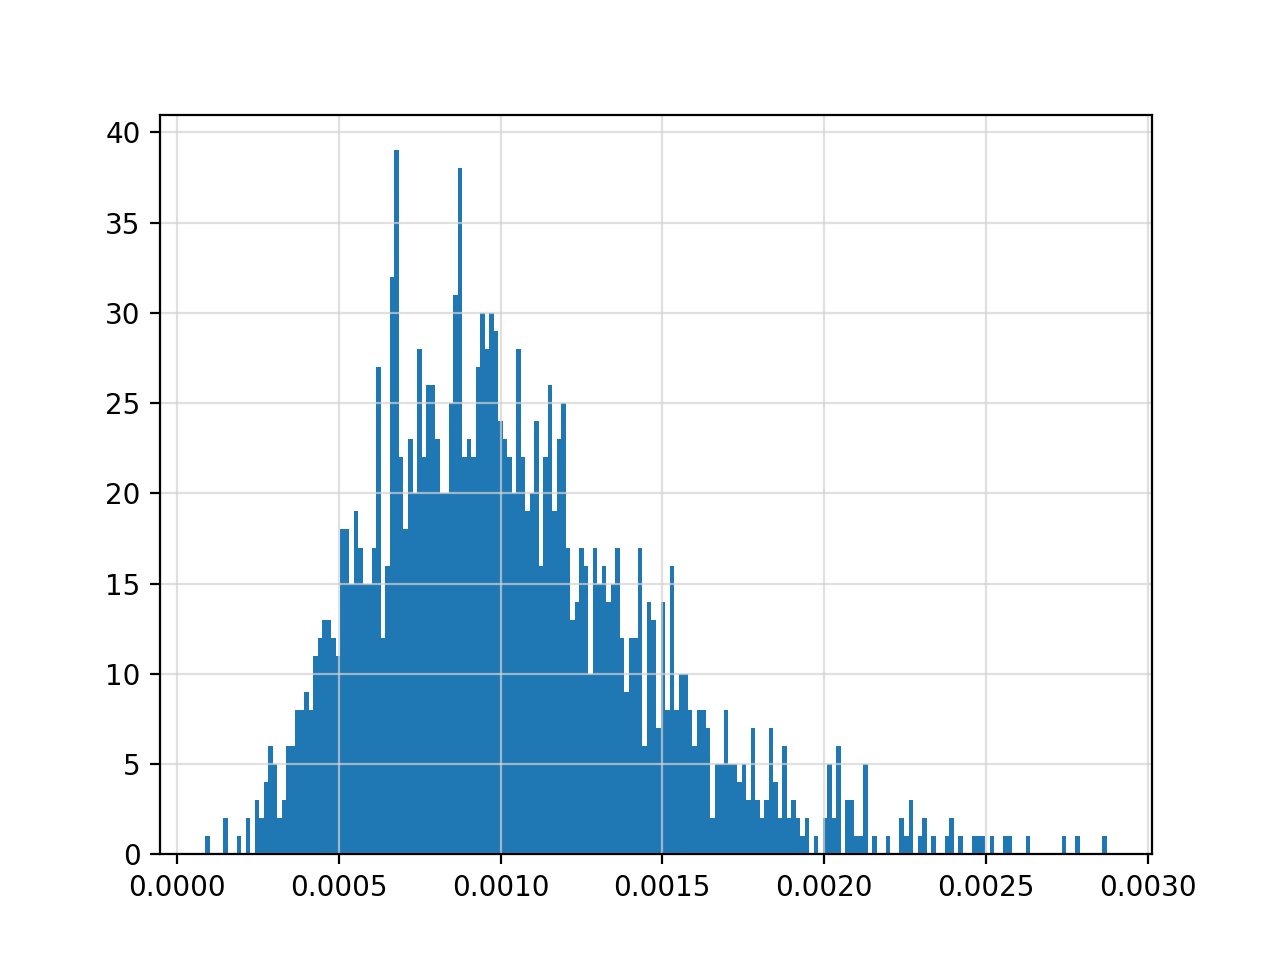



(execution time: 0.33076000213623047 s)


In [10]:
# NB OF COUNTS IN STRUCTURE CALCULATION (2D version):

# Calcul du temps d'execution:
time1 = time.time()


#Gets the point list of the structure:
c_data = m_struct.ROIContourSequence[m_ROInb].ContourSequence[m_sliceNb]
pointList = getPointList(c_data, dispNbPoints = True)


# Converts the point list in the SPECT ordinates:
cc = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)
SPECT_pointList = cc.converStructList(pointList)

SPECTpath_contour = matplotlib.path.Path(SPECT_pointList)


# Gets the corresponding SPECT slice:
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
CTzOrigin = CTimg.ImagePositionPatient[2]
corrSPECTSlice = int((m_SPECTzOrigin-CTzOrigin) / m_SPECTzSpacing)



volPixel = m_SPECTxSpacing * m_SPECTySpacing * m_SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []
for i in range(m_SPECTsizeX):
    for j in range(m_SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += m_SPECTarray[corrSPECTSlice,j,i]
            pixValues.append(m_SPECTarray[corrSPECTSlice,j,i])
            nbPix += 1

time2 = time.time()

print('rESULTS:')
print(' -> Selected slice', corrSPECTSlice)
print(' -> ROI volume:', round(volROI,1), 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> min nb of counts in a voxel:', np.min(pixValues))
print(' -> max nb of counts in a voxel:', np.max(pixValues))
print(' -> Mean nb of counts:', round(nbCountsInROI/nbPix,2))
print('\n')

fig, ax = plt.subplots()
ax.hist(pixValues, 200)
ax.grid(color='lightgray', alpha=0.7)

print('\n\n(execution time:', time2-time1, 's)')


rESULTS:
 -> Selected ROI: 0
 -> ROI volume: 6625262.6 mm3
 -> min nb of counts in a voxel: 6.290450187407259e-07
 -> max nb of counts in a voxel: 0.0045416830107569695
 -> Total nb of counts: 77.31606863747743
 -> Mean nb of counts in a pixel: 0.0




<IPython.core.display.Javascript object>


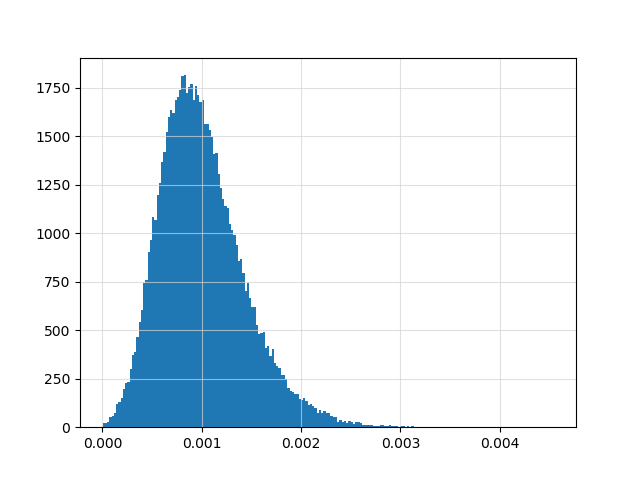



(execution time: 16.231000185012817 s)


In [54]:
# NB OF COUNTS IN STRUCTURE CALCULATION (3D version):


# Calcul du temps d'execution:
time1 = time.time()

# Variables initialization:
volPixel = m_SPECTxSpacing * m_SPECTySpacing * m_SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []

# Converter: contour point list in the SPECT coordinates
ccSPECT = coordConverter(m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTxSpacing, 
                         m_SPECTySpacing, m_SPECTsizeX, m_SPECTsizeY)


# Gets the structure on first slice:
cd = m_struct.ROIContourSequence[m_ROInb].ContourSequence[0]

# Finds the corresponding z slice in the SPECT image:
imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])
posz = int((m_SPECTzOrigin-CTimg.ImagePositionPatient[2]) / m_SPECTzSpacing)

# Gets the points list and converts it the pixel nb in SPECT img:
pl = getPointList(cd)
SPECTpath_contour = matplotlib.path.Path(ccSPECT.converStructList(pl))

# Gets the statistics from the first slice:
for i in range(m_SPECTsizeX):
    for j in range(m_SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += m_SPECTarray[posz,j,i]
            pixValues.append(m_SPECTarray[posz,j,i])
            nbPix += 1


# Gets the statistics for the other slices:
nbslices = len(m_struct.ROIContourSequence[m_ROInb].ContourSequence)

for s in range(1, nbslices):
    cd = m_struct.ROIContourSequence[m_ROInb].ContourSequence[s]
    imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
    CTimg = dicom.read_file(m_CTdict[imgID])
    z = int((m_SPECTzOrigin-CTimg.ImagePositionPatient[2]) / m_SPECTzSpacing)
    if z != posz:
        posz = z
        pl = getPointList(cd)
        SPECTpath_contour = matplotlib.path.Path(ccSPECT.converStructList(pl))
        for i in range(m_SPECTsizeX):
            for j in range(m_SPECTsizeY):
                if SPECTpath_contour.contains_point((i,j)):
                    volROI += volPixel
                    nbCountsInROI += m_SPECTarray[posz,j,i]
                    pixValues.append(m_SPECTarray[posz,j,i])
                    nbPix += 1


time2 = time.time()
print('rESULTS:')
print(' -> Selected ROI:', m_ROInb)
print(' -> ROI volume:', round(volROI,1), 'mm3')            
print(' -> min nb of counts in a voxel:', np.min(pixValues))
print(' -> max nb of counts in a voxel:', np.max(pixValues))
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts in a pixel:', round(nbCountsInROI/nbPix,2))
print('\n')

fig, ax = plt.subplots()
ax.hist(pixValues, 200)
ax.grid(color='lightgray', alpha=0.7)

print('\n\n(execution time:', time2-time1, 's)')


In [29]:
# Calculation of quantification error:


# SPECT acquisition
nbProj = 60 # total nb of proj. on two heads
timeProj = 20 #s (time for one proj on one head)

convFactor = 72 # coups / s / MBq


# Injected activity
Ainj = 90.28 #MBq
Tinj = datetime.datetime(2020,5,7,15,39)

Ares = 0 #MBq
Tres = datetime.datetime(2020,5,7,15,43)

Tacq = datetime.datetime(2020,5,7,16,0)

t = (Tacq - Tinj).total_seconds()
a0 = Ainj * math.exp(-t*math.log(2)/T1demi)
t = (Tacq - Tres).total_seconds()
a1 = Ares * math.exp(-t*math.log(2)/T1demi)

Aph = a0-a1 # activity in the phantom in MBq and at the acq time


# Calculation
measActivity = nbCountsInROI / nbProj / timeProj / convFactor


# Display of the results
print("Measured Activity in the images: ", round(measActivity, 2), "MBq")
print("Real Activity in the phantom: ", round(Aph, 2), "MBq")
print("Error in quantitation: ", round((measActivity-Aph)/Aph*100,1), "%")


Measured Activity in the images:  144.51 MBq
Real Activity in the phantom:  86.71 MBq
Error in quantitation:  66.6 %
